Number of objects just with SPLUS+WISE colors: 1910


Textarea(value='', description='Resultados 1:', layout=Layout(height='100px', width='100%'), placeholder='Pend…

Button(button_style='danger', description='Delete Line', icon='trash', style=ButtonStyle(), tooltip='Delete se…

Textarea(value='', description='Resultados 2:', layout=Layout(height='100px', width='100%'), placeholder='Pend…

Button(button_style='danger', description='Delete Line', icon='trash', style=ButtonStyle(), tooltip='Delete se…

Textarea(value='', description='Resultados 3:', layout=Layout(height='100px', width='100%'), placeholder='Pend…

Button(button_style='danger', description='Delete Line', icon='trash', style=ButtonStyle(), tooltip='Delete se…

Textarea(value='', description='Resultados 4:', layout=Layout(height='100px', width='100%'), placeholder='Pend…

Button(button_style='danger', description='Delete Line', icon='trash', style=ButtonStyle(), tooltip='Delete se…

Textarea(value='', description='Resultados 5:', layout=Layout(height='100px', width='100%'), placeholder='Pend…

Button(button_style='danger', description='Delete Line', icon='trash', style=ButtonStyle(), tooltip='Delete se…

Textarea(value='', description='Resultados 6:', layout=Layout(height='100px', width='100%'), placeholder='Pend…

Button(button_style='danger', description='Delete Line', icon='trash', style=ButtonStyle(), tooltip='Delete se…

Textarea(value='', description='Resultados 7:', layout=Layout(height='100px', width='100%'), placeholder='Pend…

Button(button_style='danger', description='Delete Line', icon='trash', style=ButtonStyle(), tooltip='Delete se…

Textarea(value='', description='Resultados 8:', layout=Layout(height='100px', width='100%'), placeholder='Pend…

Button(button_style='danger', description='Delete Line', icon='trash', style=ButtonStyle(), tooltip='Delete se…

Textarea(value='', description='Resultados 9:', layout=Layout(height='100px', width='100%'), placeholder='Pend…

Button(button_style='danger', description='Delete Line', icon='trash', style=ButtonStyle(), tooltip='Delete se…

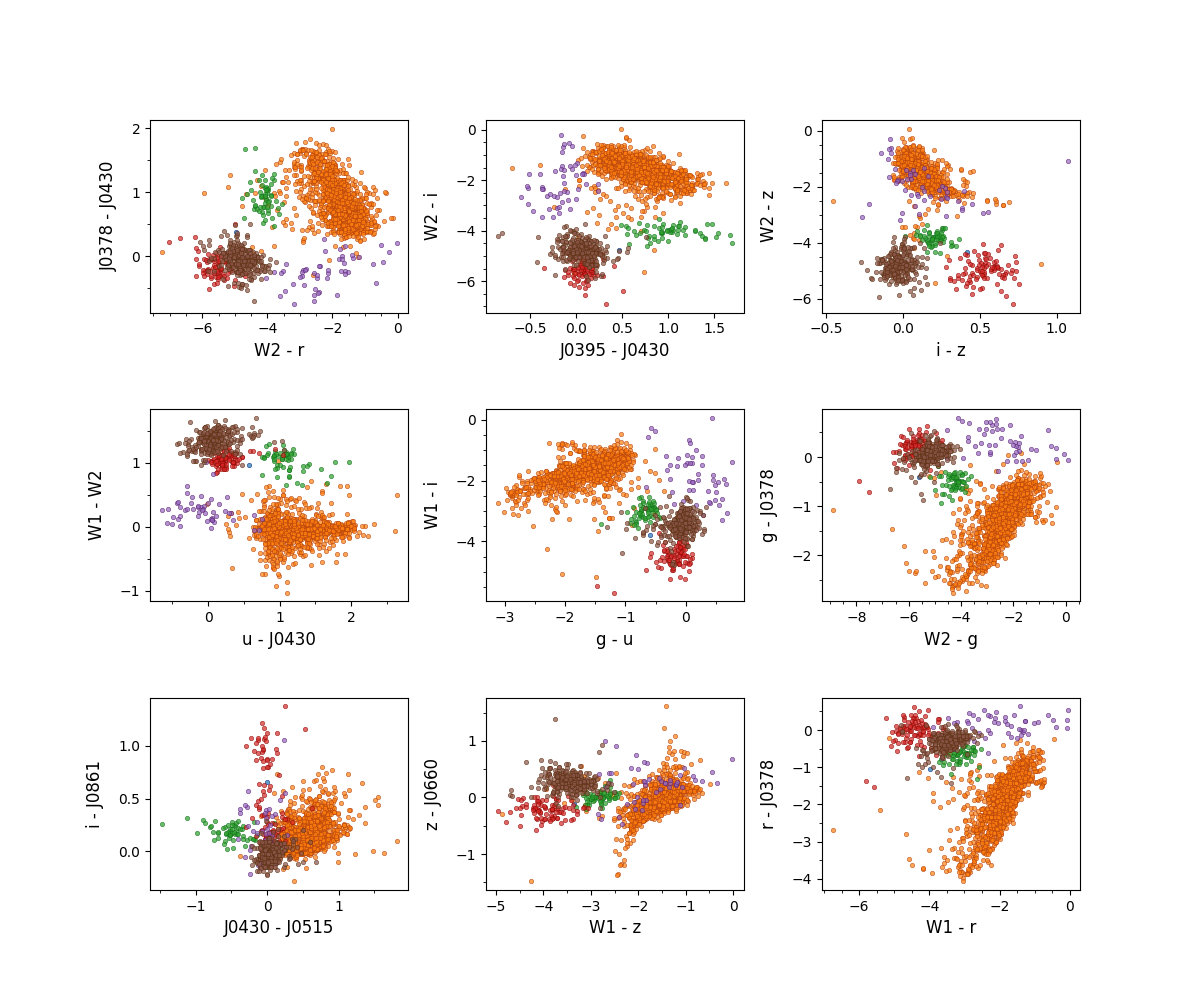

In [1]:
%matplotlib widget
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, NullFormatter
import seaborn as sns
from IPython.display import display
import ipywidgets as widgets

def open_csv_conc(pattern, exclude_pattern):
    csv_files = glob.glob(pattern)
    csv_files = [file for file in csv_files if exclude_pattern not in file]
    dfs = []

    for file in csv_files:
        df = pd.read_csv(file)
        dfs.append(df)

    combined_df = pd.concat(dfs, ignore_index=True)
    return combined_df

# Load data
df_splus_wise = open_csv_conc("../Class_wise_main_unique/*.csv", "simbad")

print("Number of objects just with SPLUS+WISE colors:", len(df_splus_wise))

# Select specific pairs based on domain knowledge or preliminary analysis
specific_pairs = [
    (('W2mag', 'r_PStotal'), ('J0378_PStotal', 'J0430_PStotal')),
    (('J0395_PStotal', 'J0430_PStotal'), ('W2mag', 'i_PStotal')),
    (('i_PStotal', 'z_PStotal'), ('W2mag', 'z_PStotal')),
    (('u_PStotal', 'J0430_PStotal'), ('W1mag', 'W2mag')),
    (('g_PStotal', 'u_PStotal'), ('W1mag', 'i_PStotal')),
    (('W2mag', 'g_PStotal'), ('g_PStotal', 'J0378_PStotal')),
    (('J0430_PStotal', 'J0515_PStotal'), ('i_PStotal', 'J0861_PStotal')),
    (('W1mag', 'z_PStotal'), ('z_PStotal', 'J0660_PStotal')),
    (('W1mag', 'r_PStotal'), ('r_PStotal', 'J0378_PStotal'))
]

# Create a figure with subplots
fig, axes = plt.subplots(3, 3, figsize=(12, 10), dpi=100)  # 3 rows, 3 columns
axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

# Define colors based on the number of labels
num_colors = len(df_splus_wise["Label"].unique())
colors = sns.color_palette("tab10", num_colors)
edge_colors = sns.color_palette("dark", num_colors)  # Define nice edge colors

# Function to calculate the slope and intercept
def calculate_slope_intercept(x1, y1, x2, y2):
    if x1 == x2:
        m = np.inf
        b = np.nan
    else:
        m = (y2 - y1) / (x2 - x1)
        b = y1 - m * x1
    return m, b

# Function to handle click events and dragging
def on_click_factory(ax, text_area, delete_button):
    points = []
    line_count = 0
    lines = []
    selected_line = None
    selected_point_index = None
    dragging = False

    def on_click(event):
        nonlocal line_count, selected_line, selected_point_index, dragging
        if event.inaxes == ax:
            if selected_line is not None and selected_point_index is not None:
                # Start dragging the selected point
                dragging = True
            else:
                points.append((event.xdata, event.ydata))
                if len(points) == 2:
                    x1, y1 = points[0]
                    x2, y2 = points[1]
                    m, b = calculate_slope_intercept(x1, y1, x2, y2)
                    line_count += 1
                    line_label = f'Linea{line_count}'
                    # Draw the line
                    line, = ax.plot([x1, x2], [y1, y2], marker='o', color='black', picker=5)  # Add picker for draggable points
                    line.set_label(line_label)  # Set the label for the line
                    lines.append(line)
                    # Add label for the line
                    ax.text((x1 + x2) / 2, (y1 + y2) / 2, line_label, fontsize=12, color='black')
                    fig.canvas.draw()
                    # Update the text area with the slope and intercept
                    text_area.value += f'{line_label} = Pendiente: {m:.6f}, Intercepto: {b:.6f}\n'
                    points.clear()

    def on_pick(event):
        nonlocal selected_line, selected_point_index
        artist = event.artist
        if artist in lines:
            if selected_line is artist:
                # Deselect the currently selected line
                selected_line.set_color('black')
                selected_line = None
                selected_point_index = None
            else:
                if selected_line is not None:
                    selected_line.set_color('black')  # Reset color of previously selected line
                selected_line = artist
                selected_point_index = event.ind[0]
                # Highlight the selected line for better visibility
                artist.set_color('red')
            fig.canvas.draw()

    def on_motion(event):
        nonlocal dragging, selected_line, selected_point_index
        if dragging and selected_line is not None and selected_point_index is not None:
            if event.inaxes == ax:
                xdata, ydata = selected_line.get_xdata(), selected_line.get_ydata()
                xdata[selected_point_index] = event.xdata
                ydata[selected_point_index] = event.ydata
                selected_line.set_xdata(xdata)
                selected_line.set_ydata(ydata)
                fig.canvas.draw()

    def on_release(event):
        nonlocal selected_line, selected_point_index, dragging
        if dragging and selected_line is not None and selected_point_index is not None:
            # Update the slope and intercept in the text area
            xdata, ydata = selected_line.get_xdata(), selected_line.get_ydata()
            x1, y1 = xdata[0], ydata[0]
            x2, y2 = xdata[1], ydata[1]
            m, b = calculate_slope_intercept(x1, y1, x2, y2)
            line_label = selected_line.get_label()
            text_area.value += f'{line_label} (Updated) = Pendiente: {m:.6f}, Intercepto: {b:.6f}\n'
            dragging = False

    def on_delete(event):
        nonlocal selected_line
        if selected_line is not None:
            for text in ax.texts:
                if text.get_text() == selected_line.get_label():
                    text.remove()
            selected_line.remove()
            lines.remove(selected_line)
            text_area.value += f'{selected_line.get_label()} (Deleted)\n'
            fig.canvas.draw()
            selected_line = None

    delete_button.on_click(on_delete)

    return on_click, on_pick, on_motion, on_release

# Plot each pair of color-color diagrams
for i, ((x1, y1), (x2, y2)) in enumerate(specific_pairs):
    ax = axes[i]

    # Iterate over groups and assign colors and markers
    for group, (label, group_data) in enumerate(df_splus_wise.groupby("Label")):
        legend_label = "Noise" if label == -1 else f"Group {label}"
        color = colors[group % num_colors]
        edge_color = edge_colors[group % num_colors]
        marker = 'o'  # You can change this if you want different markers for each group

        ax.scatter(group_data[x1] - group_data[y1], group_data[x2] - group_data[y2],
                   c=[color], s=10, marker=marker, edgecolors=[edge_color], linewidth=0.5, label=legend_label, alpha=0.7)

    # Customize axis labels with the Wise filter renaming
    xlabel = x1.replace('_PStotal', '').replace('W1mag', 'W1').replace('W2mag', 'W2')
    ylabel = y1.replace('_PStotal', '').replace('W1mag', 'W1').replace('W2mag', 'W2')
    ax.set_xlabel(f"{xlabel} - {ylabel}", fontsize=12)

    xlabel = x2.replace('_PStotal', '').replace('W1mag', 'W1').replace('W2mag', 'W2')
    ylabel = y2.replace('_PStotal', '').replace('W1mag', 'W1').replace('W2mag', 'W2')
    ax.set_ylabel(f"{xlabel} - {ylabel}", fontsize=12, labelpad=10)

    ax.tick_params(axis='both', labelsize=10)
    ax.xaxis.set_minor_locator(MultipleLocator(0.5))
    ax.yaxis.set_minor_locator(MultipleLocator(0.5))
    ax.xaxis.set_minor_formatter(NullFormatter())
    ax.yaxis.set_minor_formatter(NullFormatter())

    # Set aspect ratio to be square without changing subplot dimensions
    ax.set_aspect('auto')

    # Create a text area for each subplot
    text_area = widgets.Textarea(
        value='',
        placeholder='Pendientes e interceptos de las líneas dibujadas aparecerán aquí...',
        description=f'Resultados {i+1}:',
        layout=widgets.Layout(width='100%', height='100px'),
        disabled=False
    )
    display(text_area)

    # Create a delete button for each subplot
    delete_button = widgets.Button(
        description='Delete Line',
        disabled=False,
        button_style='danger',
        tooltip='Delete selected line',
        icon='trash'
    )
    display(delete_button)

    # Connect the click, pick, motion, and release events to their respective functions
    on_click, on_pick, on_motion, on_release = on_click_factory(ax, text_area, delete_button)
    fig.canvas.mpl_connect('button_press_event', on_click)
    fig.canvas.mpl_connect('pick_event', on_pick)
    fig.canvas.mpl_connect('motion_notify_event', on_motion)
    fig.canvas.mpl_connect('button_release_event', on_release)

# Adjust subplot spacing and layout
plt.subplots_adjust(wspace=0.3, hspace=0.5)  # Adjust to increase space between subplots

# Add legend after all subplots, centered horizontally at the bottom
# fig.legend(loc='lower center', bbox_to_anchor=(0.5, -0.1), fontsize=12, ncol=7)

# Show the plot
plt.show()

# Adjust layout and save the plot
plt.tight_layout()
# plt.savefig("Figs/color_color_diagrams_multiple_balanced.pdf", format='pdf', bbox_inches='tight', dpi=100)
# plt.close()